In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import string
import os
import glob

from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
# from keras.preprocessing import image
import keras.utils as image
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

## Defining paths of dataset

In [ ]:
token_path = "/content/gdrive/MyDrive/DL/Flickr8k_text/Flickr8k.token.txt"
train_images_path = "/content/gdrive/MyDrive/DL/Flickr8k_text/Flickr_8k.trainImages.txt"
test_images_path = "/content/gdrive/MyDrive/DL/Flickr8k_text/Flickr_8k.testImages.txt"
val_images_path = "/content/gdrive/MyDrive/DL/Flickr8k_text/Flickr_8k.devImages.txt"
images_path = "/content/gdrive/MyDrive/DL/Flicker8k_Dataset/"
glove_path = "/content/gdrive/MyDrive/DL/glove6b"


doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:
descriptions = dict()

for line in doc.split('\n'):
      tokens = line.split()
      if len(line) > 2:
        image_id = tokens[0].split('.')[0]
        image_desc = ' '.join(tokens[1:])
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)

In [ ]:
pickle.dump( descriptions , open( '/content/gdrive/MyDrive/DL/Project/baseline1/descriptions.pkl', 'wb'))

### Data cleaning :- removing punctuations and tolowercase

In [ ]:
table = str.maketrans('', '', string.punctuation)

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

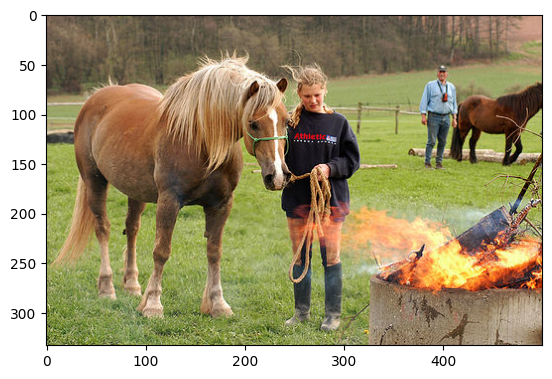

['a blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ',
 'a girl and her horse stand by a fire ',
 'a girl holding a horse s lead behind a fire ',
 'a man  and girl and two horses are near a contained fire ',
 'two people and two horses watching a fire ']

In [ ]:
pic = '10815824_2997e03d76.jpg'
x = plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['10815824_2997e03d76']

In [ ]:
vocabulary = set()

for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
        
new_descriptions = '\n'.join(lines)

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset) 


doc = open(test_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

test = set(dataset)


doc = open(val_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

validation = set(dataset)

In [ ]:
img = glob.glob(images_path + '*.jpg')

train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []

for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [ ]:
train_descriptions = dict()
test_descriptions = dict()
val_descriptions = dict()


for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]

    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

    if image_id in validation:
        if image_id not in val_descriptions:
            val_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        val_descriptions[image_id].append(desc)
    
    if image_id in test:
        if image_id not in test_descriptions:
            test_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        test_descriptions[image_id].append(desc)



In [ ]:
all_train_captions = []

for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)


In [ ]:
word_count_threshold = 10

word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
all_desc = list()

for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
embeddings_index = {} 

f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embeddings_index['child'].shape

(200,)

In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
train_img[0][len(images_path):]

'2863180332_372510aa49.jpg'

In [ ]:
encoding_train = {}
i = 1
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)  # "img" is the absoulte path of the image in drive 
    print(i)
    i += 1 
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [ ]:
import pickle
pickle.dump(encoding_train, open("/content/gdrive/MyDrive/DL/Project/baseline1/encoding_train.pkl", 'wb'))
pickle.dump(encoding_test, open("/content/gdrive/MyDrive/DL/Project/baseline1/encoding_test.pkl", 'wb'))

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                              

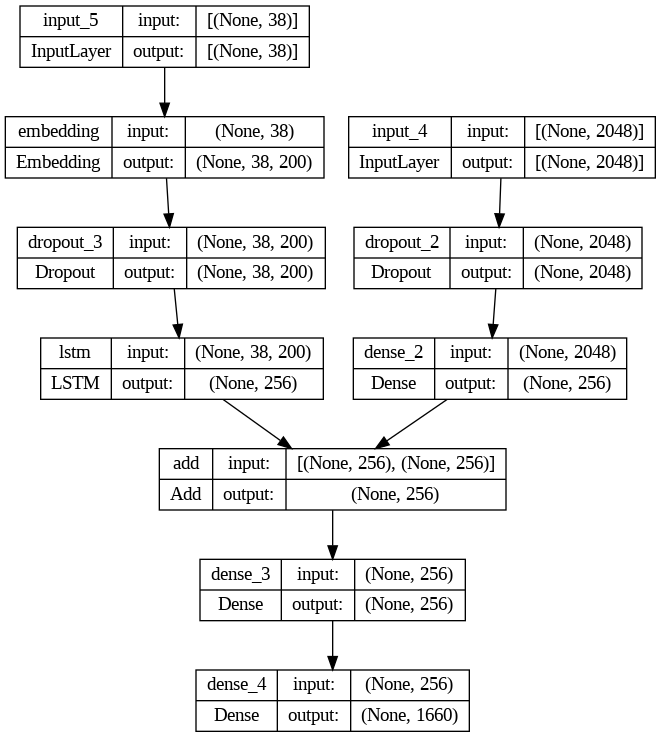

In [ ]:
from keras.utils import plot_model


plot_model(model, show_shapes=True)
plot_model(model, show_shapes=True, to_file='early_fusion.png')

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 25
batch_size = 50
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/DL/Project/baseline1/model.hdf5',
                              monitor='train_loss',
                              save_best_only=True,
                              mode = 'min',
                              verbose = 1)

In [ ]:
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])

Epoch 1/25
120/120 [==============================] - ETA: 0s - loss: 3.2775

120/120 [==============================] - 36s 248ms/step - loss: 3.2775
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 3.0819

120/120 [==============================] - 29s 241ms/step - loss: 3.0819
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 2.9526

120/120 [==============================] - 29s 243ms/step - loss: 2.9526
Epoch 4/25
120/120 [==============================] - ETA: 0s - loss: 2.8557

120/120 [==============================] - 29s 245ms/step - loss: 2.8557
Epoch 5/25
120/120 [==============================] - ETA: 0s - loss: 2.7781

120/120 [==============================] - 29s 245ms/step - loss: 2.7781
Epoch 6/25
120/120 [==============================] - ETA: 0s - loss: 2.7137

120/120 [==============================] - 29s 243ms/step - loss: 2.7137
Epoch 7/25
120/120 [==============================] - ETA: 0s - loss: 2.6618

120/120 [==============================] - 31s 254ms/step - loss: 2.6618
Epoch 8/25
120/120 [==============================] - ETA: 0s - loss: 2.6153

120/120 [==============================] - 30s 247ms/step - loss: 2.6153
Epoch 9/25
120/120 [==============================] - ETA: 0s - loss: 2.5769

120/120 [==============================] - 29s 244ms/step - loss: 2.5769
Epoch 10/25
120/120 [==============================] - ETA: 0s - loss: 2.5428

120/120 [==============================] - 29s 245ms/step - loss: 2.5428
Epoch 11/25
120/120 [==============================] - ETA: 0s - loss: 2.5096

120/120 [==============================] - 30s 248ms/step - loss: 2.5096
Epoch 12/25
120/120 [==============================] - ETA: 0s - loss: 2.4775

120/120 [==============================] - 29s 243ms/step - loss: 2.4775
Epoch 13/25
120/120 [==============================] - ETA: 0s - loss: 2.4513

120/120 [==============================] - 30s 251ms/step - loss: 2.4513
Epoch 14/25
120/120 [==============================] - ETA: 0s - loss: 2.4248

120/120 [==============================] - 29s 245ms/step - loss: 2.4248
Epoch 15/25
120/120 [==============================] - ETA: 0s - loss: 2.4053

120/120 [==============================] - 28s 237ms/step - loss: 2.4053
Epoch 16/25
120/120 [==============================] - ETA: 0s - loss: 2.3820

120/120 [==============================] - 29s 242ms/step - loss: 2.3820
Epoch 17/25
120/120 [==============================] - ETA: 0s - loss: 2.3628

120/120 [==============================] - 29s 242ms/step - loss: 2.3628
Epoch 18/25
120/120 [==============================] - ETA: 0s - loss: 2.3433

120/120 [==============================] - 29s 241ms/step - loss: 2.3433
Epoch 19/25
120/120 [==============================] - ETA: 0s - loss: 2.3281

120/120 [==============================] - 29s 242ms/step - loss: 2.3281
Epoch 20/25
120/120 [==============================] - ETA: 0s - loss: 2.3075

120/120 [==============================] - 29s 240ms/step - loss: 2.3075
Epoch 21/25
120/120 [==============================] - ETA: 0s - loss: 2.2909

120/120 [==============================] - 30s 248ms/step - loss: 2.2909
Epoch 22/25
120/120 [==============================] - ETA: 0s - loss: 2.2753

120/120 [==============================] - 30s 247ms/step - loss: 2.2753
Epoch 23/25
120/120 [==============================] - ETA: 0s - loss: 2.2588

120/120 [==============================] - 29s 240ms/step - loss: 2.2588
Epoch 24/25
120/120 [==============================] - ETA: 0s - loss: 2.2421

120/120 [==============================] - 29s 243ms/step - loss: 2.2421
Epoch 25/25
120/120 [==============================] - ETA: 0s - loss: 2.2311

120/120 [==============================] - 29s 241ms/step - loss: 2.2311


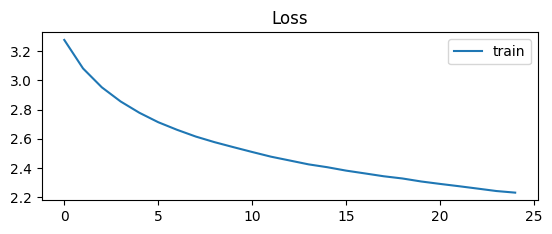

In [ ]:
from matplotlib import pyplot

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['train_loss'], label='test')
pyplot.legend()

In [ ]:
model.save('/content/gdrive/MyDrive/DL/Project/baseline1/model2.hdf5')

# **Evaluation**

In [ ]:
from keras.models import load_model
best_model = load_model("/content/gdrive/MyDrive/DL/Project/baseline1/model2.hdf5")
encoding_test = pickle.load( open('/content/gdrive/MyDrive/DL/Project/baseline1/encoding_test.pkl', 'rb'))
encoding_train = pickle.load( open('/content/gdrive/MyDrive/DL/Project/baseline1/encoding_train.pkl', 'rb'))
descriptions = pickle.load( open( '/content/gdrive/MyDrive/DL/Project/baseline1/descriptions.pkl', 'rb'))

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen = max_length)
        # print(in_text.split())
        yhat = best_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = best_model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption


## Evaluation on test set

In [ ]:
predictions = {}

for image_id, enc in encoding_test.items():

  capt = greedySearch(enc.reshape(1, 2048))
  predictions[image_id] = capt
  

In [ ]:
gen_captions = []
ref_captions = []

for image_id, capt in predictions.items():
  gen_captions.append(capt)
  ref_captions.append( descriptions[ image_id.split('.')[0] ])


In [ ]:
!pip install sacrebleu

In [ ]:
!pip install rouge_score

In [ ]:
gen_captions[1], ref_captions[1]

('a boy in a white shirt and white hat is playing baseball',
 ['a little boy holds a bat waiting for the pitch on a tiled outdoor area wearing a red shirt  white shorts  and blue flip flops that are too big for him ',
  'a little boy playing baseball outside wearing flip flops ',
  'a little boy preparing to hit a baseball',
  'a small boy wearing a red shirt swinging a baseball bat',
  'a young boy gets ready to swing his baseball bat '])

In [ ]:
from datasets import load_metric
rouge = load_metric('rouge', 'rouge-l')

In [ ]:
metric_bleu = load_metric('bleu')
gen_captionsBlue = [ s.split() for s in gen_captions]
ref_captionsBlue = [ [ s.split() for s in sent] for sent in ref_captions]

# Calculate BLEU-1 score
bleu_score_1 = metric_bleu.compute(predictions=gen_captionsBlue, references=ref_captionsBlue, max_order=1)['bleu']
# Calculate BLEU-2 score
bleu_score_2 = metric_bleu.compute(predictions=gen_captionsBlue, references=ref_captionsBlue, max_order=2)['bleu']
bleu_score_1, bleu_score_2

(0.5514119229045271, 0.3698385656308948)

In [ ]:
gen_captionsBlue[0], ref_captionsBlue[0]

In [ ]:
metric_bleu

In [ ]:
rouge.compute( predictions = gen_captions, references = ref_captions)

{'rouge1': AggregateScore(low=Score(precision=0.5969122005252804, recall=0.12281592988488986, fmeasure=0.20147385628218137), mid=Score(precision=0.6073922475154816, recall=0.1257671230109203, fmeasure=0.2057185724110585), high=Score(precision=0.6184273036962258, recall=0.12864042762446617, fmeasure=0.210063192908956)),
 'rouge2': AggregateScore(low=Score(precision=0.2546188874156894, recall=0.046876843796574315, fmeasure=0.07818266690938168), mid=Score(precision=0.2677255852399234, recall=0.049118637290328726, fmeasure=0.08187277591998543), high=Score(precision=0.2795119122482911, recall=0.0512401862780682, fmeasure=0.08544316599909836)),
 'rougeL': AggregateScore(low=Score(precision=0.5326165251054463, recall=0.10877699285464522, fmeasure=0.17857691416791927), mid=Score(precision=0.5424098811274269, recall=0.11105202605561519, fmeasure=0.1819511229604246), high=Score(precision=0.55212019667084, recall=0.11318079005890547, fmeasure=0.18541325451109977)),
 'rougeLsum': AggregateScore(lo

## Evaluation on random data

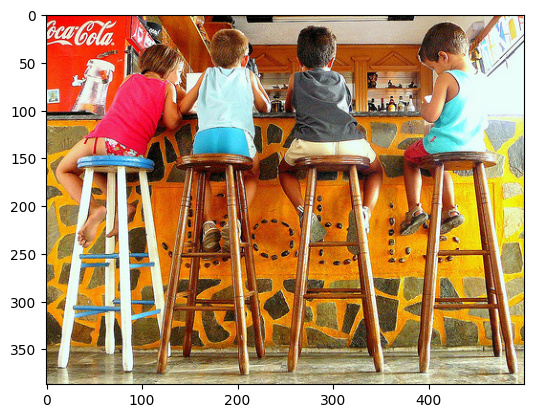

Greedy Search: a man in a red shirt is standing in front of a large yellow truck
Beam Search, K = 3: a little girl in a pink shirt is riding a red ball in a parade
Beam Search, K = 5: a little girl in a pink shirt is riding a red ball in a parade
Beam Search, K = 7: a little girl in a pink shirt is standing in front of a crowd of people
Beam Search, K = 10: a group of people sit on a structure in front of a large building


In [ ]:
pic = '2774430374_fee1d793e7.jpg'
image = encoding_test[pic].reshape((1,2048))

x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
pic = list(encoding_test.keys())[20]
image = encoding_test[pic].reshape((1,2048))   # feature vector
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

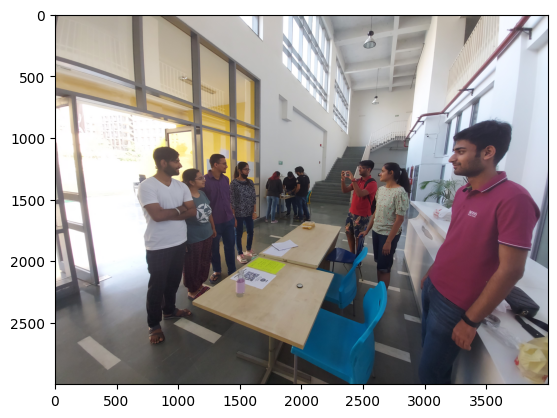

1/1 [==============================] - 0s 40ms/step
Greedy: a group of people stand on a balcony in front of a large building
Beam Search, K = 5: a group of people stand on a balcony in front of a group of
Beam Search, K = 7: a group of people stand on a balcony in front of a group of
Beam Search, K = 10: a group of people sitting on a balcony in front of a group of


In [ ]:
# run all cell accept model.fit and encoding_test = {} then run this cell for results

import keras.utils as image
from keras.utils import pad_sequences

img_drive_path = "/content/gdrive/MyDrive/fundraiser1.jpg"

x = plt.imread( img_drive_path )
plt.imshow(x)
plt.show()

feature_vector = encode(img_drive_path).reshape(1, 2048)
  
print("Greedy:",greedySearch(feature_vector))
print("Beam Search, K = 5:",beam_search_predictions(feature_vector, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(feature_vector, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(feature_vector, beam_index = 10))